In this section, we investigate the relationship between the target article sentiment and how it influences the path structure.
1. How does the sentiment score of a target topic affect the <b><u>structure</u></b> of the path chosen by players? 
2. Is there a relationship between the extremity of a target article's sentiment (highly positive/negative) and the <b><u>length</u></b> of the path taken to reach it? 
3. When players choose <b><u>shorter paths</u></b>, are these paths characterized by articles with, for example, more extreme sentiment scores? Conversely, do extreme-sentiment paths mean shorter paths? (essentially, is this a better game strategy?)

### 1. Path Sentiment and Path Structure

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [42]:
with open("df_paths1.pickle", "rb") as f:
    df = pickle.load(f)

Let's add some utility columns in the dataframe.

In [43]:
df["Scores_mean"] = df["Scores"].apply(lambda x: sum(x)/len(x))
df["Path_length"] = df["Scores"].apply(lambda x: len(x))

For this first question, we want to visualize the paths. For this, we use a heatmap and interpolate the sentiments from adjacent paths to get a better sense of the structure of paths.

In [96]:
max_path_length = 20
path_resolution = 20  # resolution between 2 articles; e.g. with 20: there are 20 points between source and 1st article clicked
score_resolution = 80 # 20 -> [-1, -0.9, ..., 0.9, 1]
score_step = (1-(-1))/score_resolution

# max_length = df_high_sentiment["Scores"].apply(len).max()  # Get the maximum length of Scores

def path_heatmap(df, title="Scores Heatmap", remove_target=False):
    path_scores_heatmap = np.zeros((score_resolution, path_resolution*max_path_length))

    for i in df.index:
        path = df.loc[i]["Scores"][:-1] if remove_target else df.loc[i]["Scores"]
        
        # fix bug: some paths are Series, not list
        if type(path) != list:
            path = list(path)[0]
        x = np.arange(len(path))
        # print(x, type(x), len(path), path, type(path))
        f = interp1d(x,path)
        path_space = np.linspace(0,len(path)-1, path_resolution*len(path))
        f_path_space = f(path_space)
        for path_ind,score in enumerate(f_path_space):
            y_ind = round(score/score_step) + score_resolution//2
            path_scores_heatmap[y_ind, min(path_ind,path_resolution*max_path_length-1)] += 1

    # Plot the heatmap
    ax = plt.imshow(np.log(np.flipud(path_scores_heatmap)+1), aspect='auto', cmap='viridis', interpolation='nearest', extent=[0,12,-1,1])
    plt.colorbar()
    plt.xlabel('Path Index')
    plt.ylabel('Sentiment score $\in[-1,1]$')
    plt.title(title)
    plt.show()

Let's visualize a random subset of the paths.

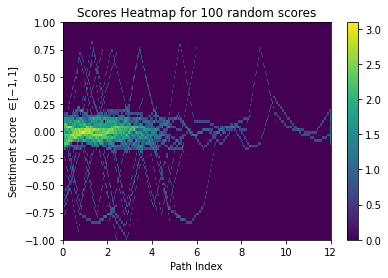

In [45]:
size=100
rand_ind = np.random.choice(df.index, size=size)
path_heatmap(df[df["Path_length"] > 2].filter(items = rand_ind, axis=0), 
             title=f"Scores Heatmap for {size} random scores")

It is clear that most of the paths are centered in the neutral sentiment zone. This is due to the sentiment evaluation method that we chose (see above) which scores a large majority of the articles as neutral. Another thing we note is that most of the "high-sentiment" articles are negative. Indeed, again in the distribution of the article scores above, we saw that there were more negative articles than positive ones.

Now, let's dive into a causal analysis on whether or not the target sentiment affects the path structure. For now, we keep the "structure" feature purely a descriptive, non-formal one. 

But first, we notice that many of the paths have very short length, and we wonder whether these are of interest for our analysis. There are about 10,000 paths with length 1 or 2:

In [46]:
len(df[(df["Path_length"] <= 2)])

10495

Out of these, only about 800 do actually reach their target (see cell below). Note that the paths that reach their target are the ones for which the column Target score is a NaN value as the target score is already present in the Scores column (since it is reached).

In [47]:
len(df[(df["Path_length"] <= 2) & (df["Target score"].apply(lambda x: np.isnan(x)))])

831

We decide that short paths that do not reach their target are "rage-quits": they do not provide useful information for our analysis (they are noise). Similarly, short paths that reach their target are also noise: they are too easy! In both cases, neither does provide useful information, so we discard these in our following analyses. Now, let's focus on splitting the data according to the target's sentiment.

In [48]:
df = df[df["Path_length"] > 2]

Now we dive into the path structure depending on the target.

Let's gather the target articles' scores in a new column. Note that we differentiate the case where the target article was found or not. We then split the dataframe in 3 frames depending on the target score. 

In [49]:
df["target_score_raw"] = df.apply(lambda x: x['Scores'][-1] if np.isnan(x['Target score']) else x['Target score'], axis=1)
df_positive = df[df["target_score_raw"] >= 0.5]
df_neutral = df[(df["target_score_raw"] > -0.5) & (df["target_score_raw"] < 0.5)]
df_negative = df[df["target_score_raw"] <= -0.5]

Note that the scores where we split the data seem arbitrary, but in fact the scores are very well split (we refer here again to the histogram of the articles' sentiment scores).

In [50]:
df_positive.describe()

,Target score,Scores_mean,Path_length,target_score_raw
count,438.000000,2030.000000,2030.000000,2030.000000
mean,0.761764,0.098503,6.032020,0.758437
std,0.055430,0.141188,3.248302,0.050272
min,0.700043,-0.865857,3.000000,0.700043
25%,0.717978,0.010624,4.000000,0.716237
50%,0.747766,0.112524,5.000000,0.750177
75%,0.777580,0.182197,7.000000,0.782183
max,0.939431,0.626832,67.000000,0.943384


In [51]:
df_negative.describe()

,Target score,Scores_mean,Path_length,target_score_raw
count,1316.000000,5960.000000,5960.000000,5960.000000
mean,-0.821085,-0.242910,5.866443,-0.816736
std,0.092857,0.170273,3.084960,0.087023
min,-1.000000,-0.942485,3.000000,-1.000000
25%,-0.879634,-0.353202,4.000000,-0.865036
50%,-0.790648,-0.225142,5.000000,-0.804227
75%,-0.740544,-0.136337,7.000000,-0.742560
max,-0.700808,0.440404,102.000000,-0.700045


In [52]:
df_neutral.describe()

,Target score,Scores_mean,Path_length,target_score_raw
count,13428.000000,57679.000000,57679.000000,57679.000000
mean,-0.026903,-0.045076,6.010506,-0.029277
std,0.109761,0.111394,3.536139,0.103377
min,-0.385264,-0.878111,3.000000,-0.385264
25%,-0.122357,-0.083277,4.000000,-0.109475
50%,-0.038557,-0.033339,5.000000,-0.040235
75%,0.057017,0.010639,7.000000,0.042937
max,0.299472,0.627172,405.000000,0.299472


[Comment on ...]

Let us now visualize the paths using the heatmap tool.

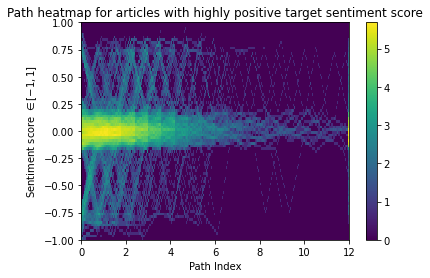

In [53]:
path_heatmap(df_positive, 
             title="Path heatmap for articles with highly positive target sentiment score", 
             remove_target=True)

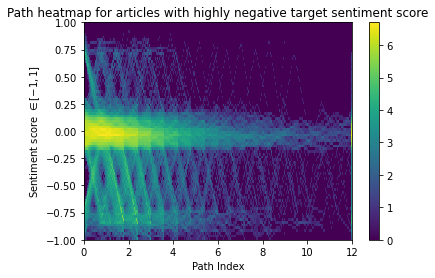

In [54]:
path_heatmap(df_negative, 
             title="Path heatmap for articles with highly negative target sentiment score", 
             remove_target=True)

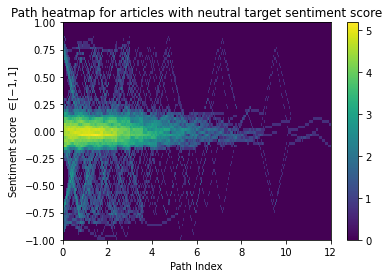

In [98]:
path_heatmap(df_neutral.filter(items=np.random.choice(df_neutral.index, size=1000), axis=0), 
             title="Path heatmap for articles with neutral target sentiment score", 
             remove_target=True)

### 2. Target sentiment ~ path length ?

Let's try making a predictive model to determine the strength of the relationship between target sentiment and path length.